In [2]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib as mlp
import matplotlib.pyplot as plt
import geopandas as gp
import seaborn as sb
import os
import re
import scipy.stats as st
%matplotlib inline
plt.style.use('ggplot')


In [3]:
sb.set_style("whitegrid")
plt.rcParams["ytick.labelsize"] = 13
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 15
plt.rcParams["xtick.labelsize"] = 15
plt.rcParams["grid.linewidth"] = 2.0
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.1
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"]= 0.9
plt.rcParams["legend.edgecolor"] = "black"
plt.rcParams["legend.fontsize"] = 16
plt.rcParams["figure.titlesize"] = 18
plt.rcParams["figure.dpi"] = 150
plt.rcParams["figure.autolayout"] = False
pd.options.display.max_columns = 1000

In [4]:
os.chdir("../../core")
import GT_helper_functions as hf
import GT_load_data as data

base_dir = "../../Outcome Measurement Data/MALARIA/"

In [5]:
# Esto no incluye toda las áreas del país. Sólo las áreas vistas en la base de datos de notifs.
notifs_das2depto = {
    "Escuintla": 5,
    "Alta Verapaz": 16,
    "Izabal" : 18,
    "Suchitepéquez" : 10,
    "Suchitepequez" : 10,
    "Santa Rosa" : 6,
    "Retalhuleu" : 11,
    "Petén Norte" : 17,
    "Peten Norte": 17,
    "Petén SurOccidente" : 17,
    "Petén SurOccidental" : 17,
    "Peten SurOriente" : 17,
    "Huehuetenango" : 13,
    "Quiché" : 14,
    "El Quiché": 14,
    "Petén Sur Oriental" : 17,
    "Baja Verapaz" : 15,
    "Sololá" : 7,
    "Zacapa" : 18,
    "Ixcán" : 14,
    "San Marcos" : 12,
    "Chimaltenango" : 4,
    "Guatemala Central" : 1,
    "Guatemala Sur" : 1,
    "Guatemala Nororiente" : 1,
    "Guatemala Noroccidente" : 1,
    "Ixil" : 14,
    "Jutiapa" : 22,
    "Chiquimula" : 20,
    "Ixcan" : 14,
    "El Progreso" : 2,
    "Guatemala Nororiental" : 1,
    "Quetzaltenango" : 9,
    "Jalapa": 21,
    "LNS": 1
}
code2depto = {
    5: "Escuintla",
    16:"Alta Verapaz",
    18: "Izabal",
    10: "Suchitepéquez",
    6: "Santa Rosa",
    11: "Retalhuleu",
    17: "Petén",
    13: "Huehuetenango",
    14: "Quiché",
    15: "Baja Verapaz",
    7: "Sololá",
    18: "Zacapa",
    12: "San Marcos",
    4: "Chimaltenango",
    1: "Guatemala",
    22: "Jutiapa",
    20: "Chiquimula",
    2: "El Progreso",
    9: "Quetzaltenango",
    3: "Sacatepequez",
    21: "Jalapa"
}

In [6]:
bednets = pd.read_csv(base_dir + "GTM - Bednets Distr.csv", index_col = 0 , low_memory=False)
notifs = pd.read_excel(base_dir + "Base de datos 2016 - 2018 NAD Consolidado 04.06.xlsx")

In [7]:
pdr = pd.read_excel(base_dir + "Movimientos MTILD y  PDR PERIODO FASE II.xls", 3, skiprows=2)
pdr.columns = ["das", 2015,2016,2017]
pdr["deptocode"] = pdr.das.apply(lambda x: notifs_das2depto.get(x.strip() if type(x) == str else "", np.NaN))
pdr = pdr.groupby("deptocode")[[2015,2016, 2017]].sum()

In [8]:
pdr

,2015,2016,2017
deptocode,,,
1.0,100.0,150.0,450.0
2.0,500.0,1500.0,1025.0
4.0,500.0,0.0,850.0
5.0,40000.0,18000.0,61100.0
6.0,500.0,100.0,7525.0
7.0,200.0,0.0,850.0
9.0,500.0,1275.0,1275.0
10.0,6000.0,0.0,4050.0
11.0,1500.0,6475.0,16000.0


In [9]:
def clean(x):
    try: 
        return x.strip().lower()
    except:
        return np.NaN
notifs["deptocode"] = notifs.AREA.map(str.strip).map(notifs_das2depto.get)
notifs["GENERO"] = notifs["GENERO"].apply(clean)
notifs["Gender"] = notifs.GENERO.map(lambda x: "Male" if x == "m" else "Female" if x == "f" else np.NaN)
notifs["Year"] = notifs["FECHA TOMA DE MUESTRA"].map(lambda y: y.year)

In [10]:
notifsSemester = notifs[notifs.Year > 2014].assign(Semester = lambda x: \
                                      x["FECHA TOMA DE MUESTRA"].map(lambda y: (2 if y.month>6 else 1)))\
    .groupby(["deptocode", "Year", "Semester"]).Year.count().unstack([1,2], fill_value = 0).stack([0,1]).rename("Notifs").reset_index()
notifsSemester["semindex"] = 2*(notifsSemester.Year - 2012) + notifsSemester.Semester

In [11]:
notifsSemester[["deptocode", "semindex", "Notifs"]].set_index(["deptocode", "semindex"]).unstack(1)

Notifs                                              
semindex     7.0    8.0     9.0     10.0    11.0    12.0   13.0
deptocode                                                      
1             3.0    0.0     9.0     2.0    10.0     3.0    0.0
2             1.0    1.0     0.0     0.0     1.0     1.0    0.0
4            10.0    1.0     2.0     1.0     1.0     1.0    0.0
5          2676.0  909.0  2135.0  1058.0  1418.0  1019.0  878.0
6            53.0   18.0   115.0    34.0    29.0     8.0    8.0
7            14.0    2.0     8.0     2.0     1.0     0.0    0.0
9             1.0    2.0     0.0     0.0     0.0     0.0    0.0
10           95.0   57.0   165.0    76.0   113.0   187.0  114.0
11           75.0   30.0    44.0    31.0    24.0    10.0    9.0
12            2.0    6.0     2.0     1.0     3.0     4.0    0.0
13           33.0   22.0    13.0     6.0     9.0     9.0    3.0
14           47.0   16.0    22.0    10.0    14.0     8.0   11.0
15           15.0    5.0     6.0     2.0     4.0     6.0    2.0
16          415.0  383.0   290.0   254.0   123.0   628.0  311.0
17           66.0   57.0    82.0    32.0    50.0    88.0   39.0
18           75.0  316.0   252.0   142.0   213.0    99.0   86.0
20            3.0    0.0     1.0     0.0     1.0     1.0    0.0
22            2.0    0.0     1.0     2.0     1.0     2.0    2.0

In [12]:
bednets.Sustit_

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
559443     True
559444     True
559445     True
559446     True
559447     True
559448     True
559449     True
559450     True
559451     True
559452     True
559453     True
559454     True
559455     True
559456     True
559457     True
559458     True
559459     True
559460     True
559461     True
559462     True
559463     True
559464     True
559465     True
559466     True
559467     True
559468     True
559469     True
559470     True
559471     True
559472     True
Name: Sustit_, Length: 5

In [13]:
bednetsSemester = bednets[(((bednets.year==2018) & (bednets.month >= 7)) == False) &(bednets.Sustit_ == False)]\
        .assign(Semester = lambda x: x.month.map(lambda y: 2 if y > 6 else 1))\
        .groupby(["year", "Semester", "CodDepto_e"])\
         .Pabellones.sum().unstack([0,1], fill_value = 0).stack([0,1]).reset_index()
bednetsSemester["semindex"] = 2*(bednetsSemester.year - 2012) + bednetsSemester.Semester

In [14]:
bednetsYears = bednets\
    .groupby(["year", "CodDepto_e"]).Pabellones.sum().unstack(0).fillna(0)

# Weighted dose
As (Abrahamowicza 2005) suggests: 
$$ cum.dose(t_{current}) = \sum_{t \leq t_{current}}{dose(t) \times w(t_{current} - t)} $$

In [15]:
def weightFunction (dt, sigma):
    return( np.exp( - (dt**2)/(2* (sigma**2) ) ) )

def invWeightFunction_sigma (w, dt):
    return( np.sqrt( - (dt**2)/(2*np.log(w)) ) )

In [16]:
# for three years: 
sigma2 = invWeightFunction_sigma(0.5, 3)
print(sigma2)

2.547965400864057


In [17]:
# for three years: 
sigma3 = invWeightFunction_sigma(0.5, 6)
print(sigma3)

5.095930801728114


In [18]:
# for 5 years: 
sigma5 = invWeightFunction_sigma(0.5, 10)
print(sigma5)

8.493218002880191


In [21]:
# Calculate weights for 10 years
# for 1.5 years
w2 = [weightFunction(t, sigma2) for t in range(20,-1,-1)]
print(w2)
# for 3 years: 
w3 = [weightFunction(t, sigma3) for t in range(20,-1,-1)]
print(w3)
# for 5 years: 
w5 = [weightFunction(t, sigma5) for t in range(20,-1,-1)]
print(w5)

[4.177236667929939e-14, 8.420781453308248e-13, 1.4551915228366858e-11, 2.155720052046913e-10, 2.7375938226945685e-09, 2.98023223876953e-08, 2.781221960964482e-07, 2.224977568771586e-06, 1.5258789062500007e-05, 8.970547438205558e-05, 0.0004520872618590284, 0.001953125, 0.007233396189744457, 0.022964601441806235, 0.0625, 0.14581612994701457, 0.29163225989402913, 0.5, 0.7348672461377994, 0.9258747122872905, 1.0]
[0.0004520872618590284, 0.0009579395387391747, 0.001953125, 0.0038317581549566996, 0.007233396189744457, 0.013139006488339289, 0.022964601441806235, 0.038621702060290294, 0.0625, 0.09732059081705585, 0.14581612994701457, 0.21022410381342865, 0.29163225989402913, 0.3892823632682234, 0.5, 0.6179472329646446, 0.7348672461377994, 0.8408964152537145, 0.9258747122872905, 0.980930087668915, 1.0]
[0.0625, 0.08189958774114772, 0.10584316404531594, 0.1349035295630534, 0.16957554093095903, 0.21022410381342868, 0.2570284566640167, 0.30992692498474667, 0.36856730432277535, 0.43226861565393265,

In [22]:

bednetsSemester2 = bednetsSemester.groupby(["semindex", "CodDepto_e"])[0].sum().unstack(0).fillna(0)
cumBednets3 = bednetsSemester2.copy()
for d, row in bednetsSemester2.iterrows():
    for i in range(0,len(row)+1):
        cumBednets3.loc[d, row.index[i-1] ] = np.dot( row.values[0:i], w3[-i:] ) if i>0 else 0
cumBednets5 = bednetsSemester2.copy()
for d, row in bednetsSemester2.iterrows():
    for i in range(0,len(row)+1):
        cumBednets5.loc[d, row.index[i-1] ] = np.dot( row.values[0:i], w5[-i:] ) if i>0 else 0
cumBednets2 = bednetsSemester2.copy()
for d, row in bednetsSemester2.iterrows():
    for i in range(0,len(row)+1):
        cumBednets2.loc[d, row.index[i-1] ] = np.dot( row.values[0:i], w2[-i:] ) if i>0 else 0

In [23]:
cumBednets2

semindex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CodDepto_e,,,,,,,,,,,,,
2.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5137.000000,4756.218397,3775.013043,2568.500000,1498.114919,749.057460
4.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2500.000000,2314.686781,2183.168115,1570.352650,983.344717,537.540325,257.154762
5.0,53944.0,59190.385480,49035.390441,46365.027201,42550.510133,34602.146292,28518.059516,38330.756809,36481.175559,45368.919326,36980.869679,25884.448810,21376.552756
6.0,0.0,0.000000,0.000000,0.000000,0.000000,6243.000000,9024.235829,12740.313784,18772.738240,24846.426703,19704.535187,13779.785182,8450.799469
7.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6070.000000,6001.059504,6368.402449,5176.719598,3494.145514,2083.829778
9.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19881.000000,32535.315155,27790.653656,20861.291925,13348.367805,8543.901839
10.0,0.0,63792.000000,106216.399646,90838.421674,66826.809420,42402.235031,36677.238512,55565.050917,61413.536487,87881.997600,70170.152450,49525.003173,30629.295594
11.0,0.0,29612.000000,54320.001980,48069.696277,35872.358120,23116.128625,23173.689928,51012.694791,58002.578391,59243.265535,44294.656832,29146.308575,41144.236042
12.0,0.0,19487.000000,24703.520518,34289.609484,27467.373506,19202.469315,14348.824770,31098.600062,32497.047955,38945.928074,30046.321578,20487.909828,12276.454539


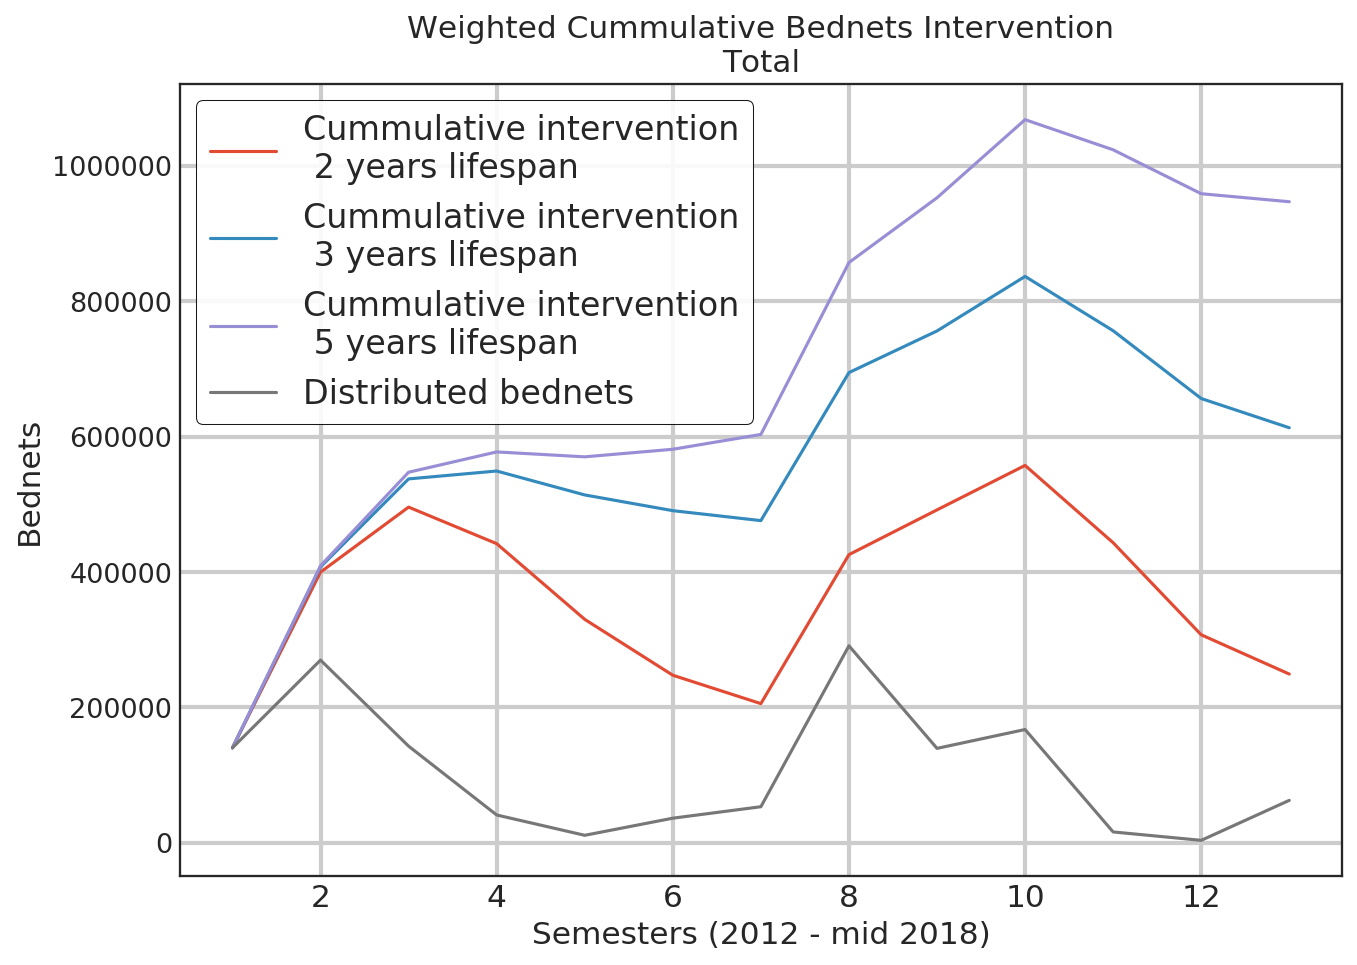

In [24]:
mlp.rcParams["figure.figsize"] = (10,7)
cumBednets2.sum().plot(label="Cummulative intervention\n 2 years lifespan")
cumBednets3.sum().plot(label="Cummulative intervention\n 3 years lifespan")
cumBednets5.sum().plot(label="Cummulative intervention\n 5 years lifespan")
bednetsSemester2.sum().plot(label="Distributed bednets")
plt.title("Weighted Cummulative Bednets Intervention\nTotal")
plt.ylabel("Bednets")
plt.xlabel("Semesters (2012 - mid 2018)")
plt.legend()

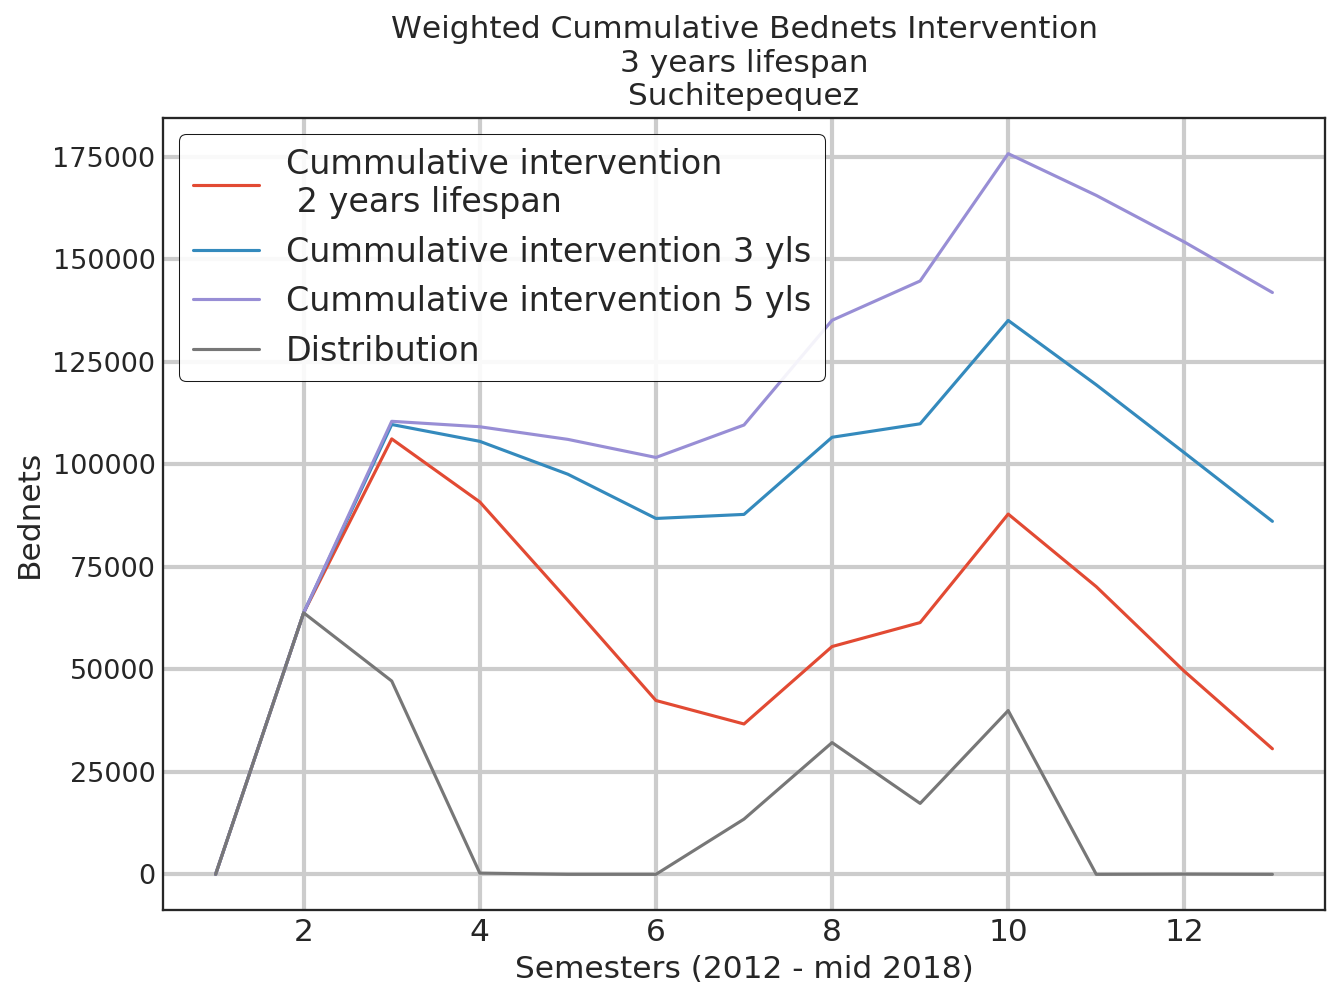

In [25]:
mlp.rcParams["figure.figsize"] = (10,7)
cumBednets2.loc[10].plot(label="Cummulative intervention\n 2 years lifespan")
cumBednets3.loc[10].plot(label="Cummulative intervention 3 yls")
cumBednets5.loc[10].plot(label="Cummulative intervention 5 yls")
bednetsSemester2.loc[10].plot(label="Distribution")
plt.title("Weighted Cummulative Bednets Intervention\n3 years lifespan\nSuchitepequez")
plt.ylabel("Bednets")
plt.xlabel("Semesters (2012 - mid 2018)")
plt.legend()

In [260]:
notifsSemester.groupby(["semindex", "deptocode"]).Notifs.sum().unstack(0).fillna(0)

semindex,7.0,8.0,9.0,10.0,11.0,12.0,13.0
deptocode,,,,,,,
1,3.0,0.0,9.0,2.0,10.0,3.0,0.0
2,1.0,1.0,0.0,0.0,1.0,1.0,0.0
4,10.0,1.0,2.0,1.0,1.0,1.0,0.0
5,2676.0,909.0,2135.0,1058.0,1418.0,1019.0,878.0
6,53.0,18.0,115.0,34.0,29.0,8.0,8.0
7,14.0,2.0,8.0,2.0,1.0,0.0,0.0
9,1.0,2.0,0.0,0.0,0.0,0.0,0.0
10,95.0,57.0,165.0,76.0,113.0,187.0,114.0
11,75.0,30.0,44.0,31.0,24.0,10.0,9.0


In [26]:
def lagBednet(i):
    def lagCalc(x):
        bednetsLag = bednetsSemester[(bednetsSemester.CodDepto_e == x.deptocode) &(bednetsSemester.semindex == (x.semindex - i))][[0]]
        bednetsLag2 = bednetsSemester[(bednetsSemester.CodDepto_e == x.deptocode) &(bednetsSemester.semindex == (x.semindex - i - 1))][[0]]
        
        if len(bednetsLag) == 1:
            return bednetsLag2.values[0][0]+bednetsLag.values[0][0]
        else:
            return 0
    return lagCalc

for i in range(1,5):
    notifsSemester["bednetsLagSem_"+str(i)] = notifsSemester.apply(lagBednet(i), axis = 1)

In [27]:
def lagNotifs(i):
    def lagCalc(x):
        notifsLag = notifsSemester[(notifsSemester.deptocode == x.deptocode) &(notifsSemester.semindex == (x.semindex - i))].Notifs
        if len(notifsLag) == 1:
            return notifsLag.values[0]
        else:
            return 0
    return lagCalc

for i in range(1,5):
    notifsSemester["notifsLagSem_"+str(i)] = notifsSemester.apply(lagNotifs(i), axis = 1)

In [28]:
# Clean notifs semester dataframe
notifsSemester = notifsSemester\
        [[x for x in notifsSemester.columns if ( (not x.endswith("_y")) & (not x.endswith("_x")) &
         (not x.startswith("cumBN") ))]]

notifsSemester = notifsSemester.merge(cumBednets2.stack().rename("cumBN").reset_index(), how="left",
                     left_on=["deptocode", "semindex"],
                    right_on = ["CodDepto_e", "semindex"])
notifsSemester.loc[notifsSemester["cumBN"].isna() ,"cumBN"] = 0

In [29]:
def lagCol(i, col, df):
    def lagCalc(x):
        cumLag = df[(notifsSemester.deptocode == x.deptocode) &(notifsSemester.semindex == (x.semindex - i))][col]
        if len(cumLag) == 1:
            return cumLag.values[0]
        else:
            return 0
    return lagCalc

In [30]:
for i in range(1,5):
    notifsSemester["cumBNLagSem_"+str(i)] = notifsSemester.apply(lagCol(i, "cumBN", notifsSemester), axis = 1)

In [264]:
notifsSemester.semindex.value_counts()

13.0    18
12.0    18
11.0    18
10.0    18
9.0     18
8.0     18
7.0     18
Name: semindex, dtype: int64

In [31]:
notifsSemester.to_csv("/tmp/malaria_panel_data.csv")